# Exploration de la méthode GNN

Les Graph Neural Networks (GNNs) sont une extension des réseaux neuronaux classiques pour travailler sur des données en structure de graphe. 

### **Comment ça marche :**
1. **Propagation d'informations :** Chaque nœud agrège les informations de ses voisins à l'aide de mécanismes comme la convolution sur les graphes.
2. **Utilisation des caractéristiques des nœuds (X) :** Les GNN exploitent à la fois les caractéristiques des nœuds (par exemple, `X`) et la structure du graphe (matrice d'adjacence `W`).
3. **Apprentissage supervisé :** Les GNNs peuvent prédire les classes des nœuds en apprenant des représentations enrichies pour chaque nœud dans le graphe.

### **Avantage des GNNs :**
- Ils intègrent les informations de structure et de caractéristiques, offrant une vision globale du graphe.
- Cependant, ils sont coûteux en calcul et nécessitent une supervision.

Nous explorons maintenant une alternative à GNN appelée **DeepWalk**, qui se concentre principalement sur la structure du graphe.


# Présentation de DeepWalk

DeepWalk est une méthode d'embedding des graphes inspirée des techniques NLP (comme Word2Vec). Elle convertit les graphes en représentations vectorielles des nœuds.

### **Étapes principales :**
1. **Génération de random walks :** À partir de chaque nœud, DeepWalk effectue des parcours aléatoires pour capturer le contexte des nœuds voisins.
2. **Apprentissage des embeddings :** Les séquences générées sont traitées comme des "phrases" pour entraîner un modèle Word2Vec.
3. **Résultat :** Chaque nœud obtient une représentation vectorielle (embedding) qui encode sa position et ses relations dans le graphe.




In [110]:
# Import necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [88]:

# File paths
edges_file_path = 'C:/Users/LG Gram/Downloads/cora/cora.cites'
content_file_path = 'C:/Users/LG Gram/Downloads/cora/cora.content'

In [89]:
# Load the datasets
edges = pd.read_csv(edges_file_path, sep='\t', header=None, names=['source', 'target'])
content = pd.read_csv(content_file_path, sep='\t', header=None)

In [90]:
# Data previews
print("Edge list preview:")
print(edges.head())
print("\nContent file preview:")
print(content.head())

Edge list preview:
   source   target
0      35     1033
1      35   103482
2      35   103515
3      35  1050679
4      35  1103960

Content file preview:
      0     1     2     3     4     5     6     7     8     9     ...  1425  \
0    31336     0     0     0     0     0     0     0     0     0  ...     0   
1  1061127     0     0     0     0     0     0     0     0     0  ...     0   
2  1106406     0     0     0     0     0     0     0     0     0  ...     0   
3    13195     0     0     0     0     0     0     0     0     0  ...     0   
4    37879     0     0     0     0     0     0     0     0     0  ...     0   

   1426  1427  1428  1429  1430  1431  1432  1433                    1434  
0     0     1     0     0     0     0     0     0         Neural_Networks  
1     1     0     0     0     0     0     0     0           Rule_Learning  
2     0     0     0     0     0     0     0     0  Reinforcement_Learning  
3     0     0     0     0     0     0     0     0  Reinforcement_

In [91]:
# Extract features and labels
node_features = content.iloc[:, 1:-1].values
labels = content.iloc[:, -1].astype('category').cat.codes.values
node_ids = content.iloc[:, 0].values

In [92]:
# Statistics
print(f"Number of nodes: {len(node_ids)}")
print(f"Number of edges: {len(edges)}")
print(f"Number of features: {node_features.shape[1]}")
print(f"Number of classes: {len(set(labels))}")

Number of nodes: 2708
Number of edges: 5429
Number of features: 1433
Number of classes: 7


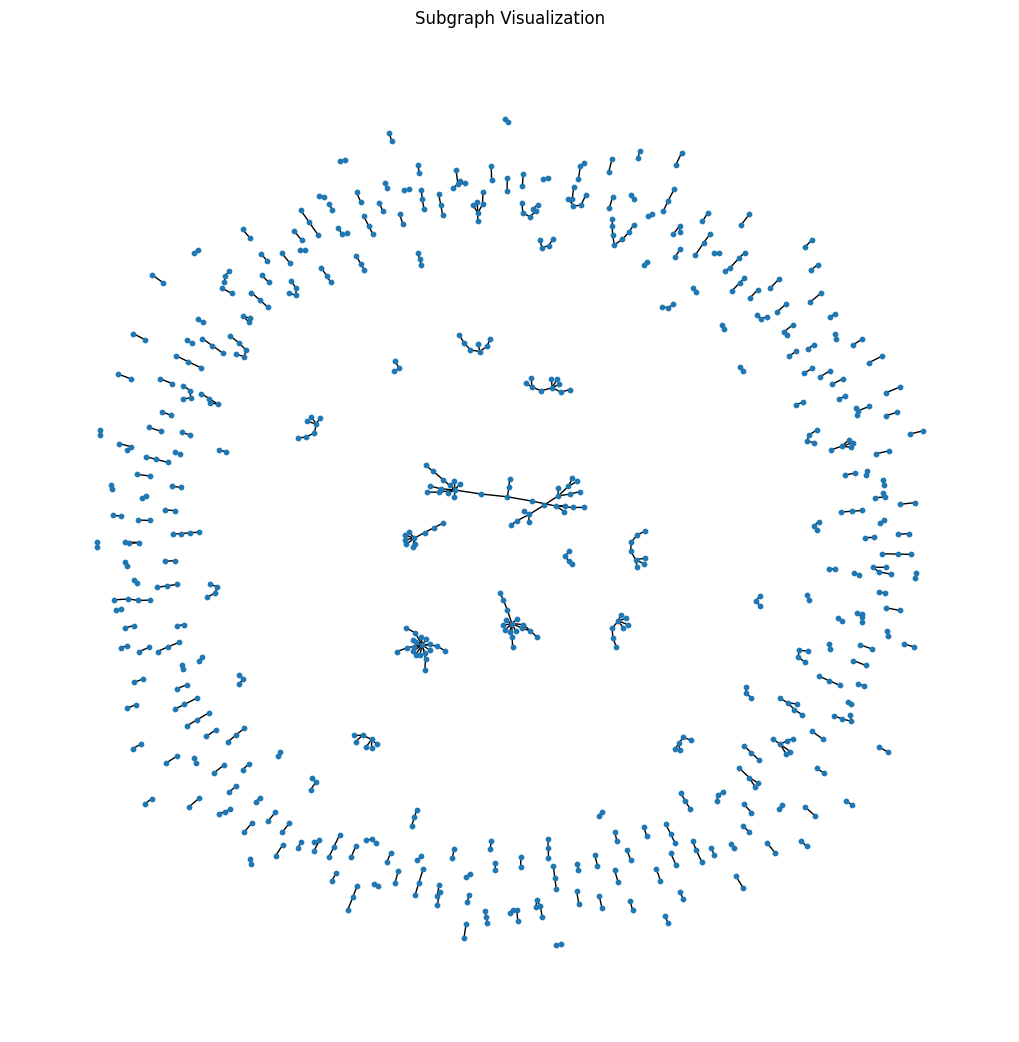

In [93]:
# Visualize the graph structure (subgraph for simplicity)
G = nx.from_pandas_edgelist(edges.sample(500), source="source", target="target")
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=10)
plt.title("Subgraph Visualization")
plt.show()

# Analyse de la Visualisation du Sous-Graphe

### **1. Structure Globale**
- L'image montre un sous-graphe extrait d'un graphe plus large. Les nœuds représentent des entités (comme des articles scientifiques dans le dataset Cora), et les liens entre les nœuds représentent leurs relations (citations dans ce cas).
- Le graphe semble être **sparse** (majorité des nœuds sont faiblement connectés) :
  - Plusieurs **clusters isolés** ou composantes connexes apparaissent.
  - Une structure centrale légèrement plus dense est visible, représentant probablement des groupes de nœuds plus connectés.

---

### **2. Observations Clés**
- **Clusters bien définis** :
  - Des regroupements distincts de nœuds (comme dans le centre) suggèrent que certains nœuds partagent des relations plus fortes. Ces clusters pourraient correspondre à des sous-communautés ou groupes d'entités fortement connectées.
- **Nœuds isolés** :
  - Beaucoup de nœuds semblent être isolés ou faiblement connectés, ce qui pourrait compliquer leur intégration dans des modèles utilisant la structure du graphe.
- **Manque de connectivité globale** :
  - Le graphe ne semble pas fortement connecté dans son ensemble, ce qui pourrait indiquer que le dataset contient plusieurs sous-graphes non reliés.

---

### **3. Implications pour les Modèles**
- **Pour DeepWalk** :
  - Les clusters définis sont idéaux pour l'apprentissage des représentations, car les random walks peuvent capturer des relations locales.
  - Les nœuds isolés pourraient avoir des embeddings moins informatifs, car ils n'ont que peu ou pas de contexte à exploiter.
- **Pour GNN** :
  - Les modèles GNN profiteront des clusters denses pour propager les informations. Cependant, les nœuds isolés ou faiblement connectés pourraient être sous-optimaux pour la classification, car ils ne bénéficieront pas d'une agrégation efficace.

In [94]:
# Map nodes to indices
node_map = {node_id: idx for idx, node_id in enumerate(node_ids)}
edges['source'] = edges['source'].map(node_map)
edges['target'] = edges['target'].map(node_map)

In [95]:
# Create a PyTorch Geometric data object
edge_index = torch.tensor(edges.values.T, dtype=torch.long)
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)
print(data)

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])


# GGN Implementation

In [96]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [97]:
# Model, optimizer, and loss function
input_dim = x.shape[1]
hidden_dim = 16
output_dim = len(torch.unique(y))
model = GCN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [98]:
# Split data into train and test sets
train_mask = torch.rand(len(y)) < 0.8
test_mask = ~train_mask

In [99]:
# Train the GCN
losses = []
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.9550012350082397
Epoch 10, Loss: 0.7116573452949524
Epoch 20, Loss: 0.3223079741001129
Epoch 30, Loss: 0.218238964676857
Epoch 40, Loss: 0.1620628386735916
Epoch 50, Loss: 0.12735559046268463
Epoch 60, Loss: 0.10422805696725845
Epoch 70, Loss: 0.0874485969543457
Epoch 80, Loss: 0.0749104768037796
Epoch 90, Loss: 0.06502509117126465


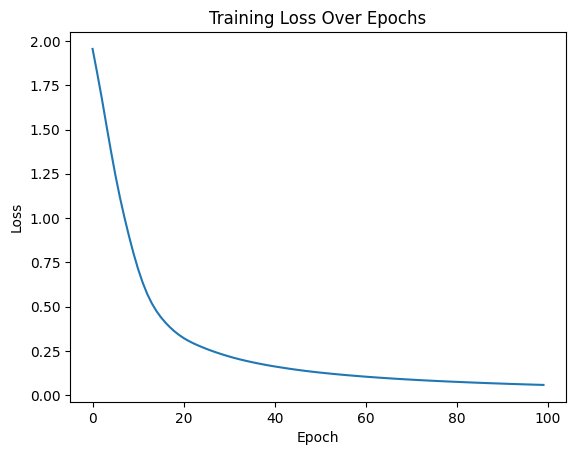

In [100]:
# Plot the training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# Analyse de la Courbe de Perte (Loss)

### **1. Description de la Courbe**
- La courbe montre l'évolution de la perte (loss) pendant l'entraînement du modèle GNN sur 100 époques.
- **Tendance générale** :
  - La perte commence à un niveau élevé (~2.0) et diminue rapidement pendant les premières époques.
  - À partir de l'époque 40 environ, la diminution ralentit, indiquant une convergence vers une valeur minimale.

---

### **2. Observations Clés**
- **Phase initiale (0-20 époques)** :
  - Une forte diminution de la perte est observée, ce qui indique que le modèle apprend rapidement les représentations de base.
- **Phase intermédiaire (20-60 époques)** :
  - La courbe montre une diminution plus progressive, ce qui est typique lorsque le modèle affine ses paramètres.
- **Phase de convergence (60-100 époques)** :
  - La perte atteint une valeur stable proche de zéro, suggérant que le modèle a convergé.

---

### **3. Interprétation**
- La diminution constante de la perte montre que le modèle optimise efficacement sa fonction d'objectif.
- **Absence d'overfitting visible** :
  - La perte continue de diminuer sans montrer de signes de surajustement. Cela pourrait indiquer que l'ensemble de données d'entraînement est bien adapté à l'architecture utilisée.
- La convergence montre que l'apprentissage s'est stabilisé, mais des améliorations supplémentaires pourraient nécessiter des ajustements de l'architecture ou des hyperparamètres.

---



---

### **Conclusion**
La courbe montre un entraînement efficace avec une convergence appropriée. L'absence de su


In [101]:
# Evaluate the GCN
model.eval()
_, pred = model(data).max(dim=1)
correct = int((pred[test_mask] == y[test_mask]).sum())
accuracy = correct / int(test_mask.sum())
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8398


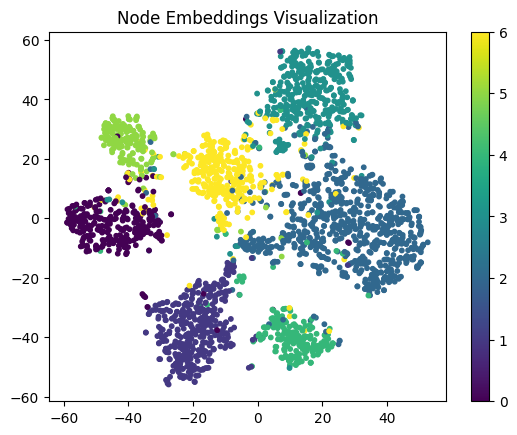

In [104]:
# Visualize predictions (embedding space)
embeddings = model.conv1(data.x, data.edge_index).detach().numpy()
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y, cmap="viridis", s=10)
plt.colorbar()
plt.title("Node Embeddings Visualization")
plt.show()

# Analyse de la Visualisation des Embeddings des Nœuds

### **1. Description de la Visualisation**
- La projection en 2D montre les embeddings des nœuds générés par le modèle GNN, réduits avec t-SNE pour faciliter l'interprétation visuelle.
- Les couleurs représentent les classes des nœuds (0 à 6), et les clusters indiquent comment les embeddings différencient ces classes.

---

### **2. Observations Clés**
- **Clusters bien définis** :
  - Les classes `1`, `2`, et `3` forment des regroupements distincts, ce qui montre que le modèle a bien appris à séparer ces classes dans l'espace des embeddings.
- **Overlap entre classes** :
  - Les classes `5` et `6` semblent avoir des chevauchements significatifs avec d'autres classes, suggérant des difficultés pour le modèle à les différencier complètement.
  - La classe `0` est également dispersée, ce qui peut indiquer une difficulté à bien isoler cette classe.
- **Distances entre clusters** :
  - Certains clusters sont proches les uns des autres (par exemple, `5` et `6`), ce qui peut refléter des similitudes dans les caractéristiques des nœuds de ces classes.

---

### **3. Interprétation**
- **Points positifs** :
  - Les classes avec des clusters bien séparés (comme `2` et `3`) indiquent que le modèle a appris des représentations discriminatives pour ces groupes.
  - Cela se traduit généralement par une meilleure précision et un rappel élevé pour ces classes.
- **Limites** :
  - Les overlaps entre les classes (par exemple, `5` et `6`) reflètent une confusion dans les prédictions du modèle, ce qui est confirmé par les métriques plus faibles pour ces classes.
  - Les classes dispersées comme `0` pourraient bénéficier d'un ajustement des hyperparamètres du modèle pour renforcer la séparation.

---




In [111]:
# Use the embeddings from the first GCN layer as features for classification
embeddings = model.conv1(data.x, data.edge_index).detach().numpy()

In [114]:
# Split embeddings into train and test sets using the same masks as the GCN
X_train = embeddings[train_mask.numpy()]
X_test = embeddings[test_mask.numpy()]
y_train = y[train_mask.numpy()] 
y_test = y[test_mask.numpy()]

In [115]:
# Function to evaluate models
def evaluate_model(model, param_grid):
    """
    Function to perform hyperparameter tuning, evaluate a classification model,
    and visualize its performance with a confusion matrix and metrics table.
    """
    print(f"\nEvaluating {model.__class__.__name__}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best parameters and accuracy
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    
    # Predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df[['precision', 'recall', 'f1-score', 'support']]
    
    # Overall Accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    metrics_df.loc['accuracy'] = [overall_accuracy, overall_accuracy, overall_accuracy, len(y_test)]
    
    # Display metrics
    print("Metrics Table:")
    print(metrics_df)
    return metrics_df


Evaluating RandomForestClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.954466763305032


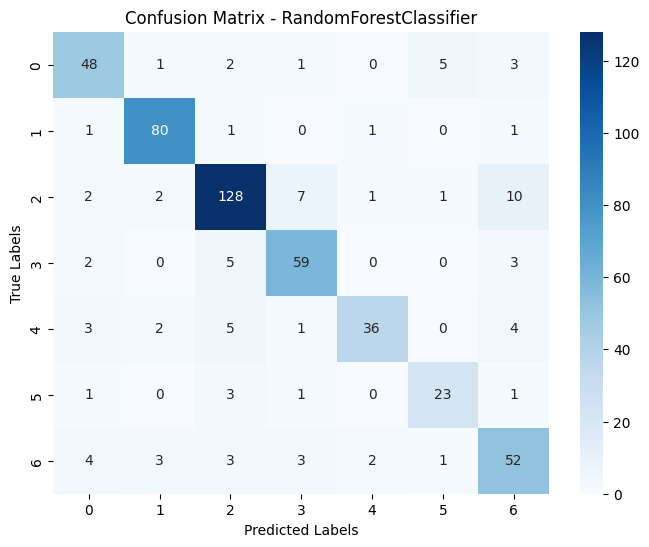

Metrics Table:
              precision    recall  f1-score  support
0              0.786885  0.800000  0.793388     60.0
1              0.909091  0.952381  0.930233     84.0
2              0.870748  0.847682  0.859060    151.0
3              0.819444  0.855072  0.836879     69.0
4              0.900000  0.705882  0.791209     51.0
5              0.766667  0.793103  0.779661     29.0
6              0.702703  0.764706  0.732394     68.0
accuracy       0.832031  0.832031  0.832031    512.0
macro avg      0.822220  0.816975  0.817546    512.0
weighted avg   0.834997  0.832031  0.831973    512.0


,precision,recall,f1-score,support
0,0.786885,0.800000,0.793388,60.0
1,0.909091,0.952381,0.930233,84.0
2,0.870748,0.847682,0.859060,151.0
3,0.819444,0.855072,0.836879,69.0
4,0.900000,0.705882,0.791209,51.0
5,0.766667,0.793103,0.779661,29.0
6,0.702703,0.764706,0.732394,68.0
accuracy,0.832031,0.832031,0.832031,512.0
macro avg,0.822220,0.816975,0.817546,512.0
weighted avg,0.834997,0.832031,0.831973,512.0


In [116]:
# Model Evaluations
# ===========================

# 1. Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
evaluate_model(RandomForestClassifier(random_state=42), rf_param_grid)

# Analyse des Résultats pour Random Forest Classifier

### **1. Matrice de Confusion**
- La matrice de confusion montre une performance globale solide avec une majorité de prédictions correctes sur les classes principales :
  - La classe `2` a le plus grand nombre de prédictions correctes (128).
  - Les classes `1`, `3`, et `4` présentent également des prédictions globalement précises.
- **Confusions notables** :
  - Les classes `5` et `6` montrent des confusions avec d'autres classes, notamment avec `2` et `3`.
  - Ces confusions reflètent des chevauchements potentiels dans leurs caractéristiques ou leur connectivité dans le graphe.

---

### **2. Tableau des Métriques**
Le tableau des métriques fournit des détails par classe :

#### Observations Clés :
- **Précision Globale (accuracy)** : 83.20%, ce qui indique que le modèle est globalement performant.
- **Classes avec Meilleures Performances** :
  - La classe `1` a une précision exceptionnelle (90.91%) et un F1-score élevé (93.02%), indiquant que le modèle distingue bien cette classe.
  - La classe `2` a également de très bonnes performances avec un F1-score de 85.91%.
- **Classes avec Faibles Performances** :
  - La classe `6` a un F1-score relativement faible (73.23%) et montre une précision modérée (70.27%), suggérant des confusions fréquentes.
  - La classe `5`, bien que petite (support = 29), montre une précision correcte (76.67%) mais un rappel plus faible (79.31%).

#### Moyennes :
- **Macro avg** (moyenne non pondérée) :
  - La précision moyenne est de 82.22%, montrant une performance équilibrée sur les classes.
  - Le rappel moyen est légèrement plus bas (81.70%), indiquant une difficulté à capturer quelques classes.
- **Weighted avg** (pondérée par le support) :
  - Très proche de l'accuracy globale (83.20%), confirmant que les classes majoritaires influencent davantage les performances globales.

---

### **3. Interprétation**
- **Forces** :
  - Random Forest est particulièrement performant pour les classes majoritaires comme `1`, `2`, et `3`, qui bénéficient d'un bon support dans les données.
  - Sa robustesse face aux données complexes est confirmée par un F1-score élevé pour les classes majoritaires.
- **Limites** :
  - Les classes minoritaires (`5` et `6`) restent plus difficiles à capturer, montrant des confusions et des métriques légèrement inférieures.
  - Cela peut être dû à un déséquilibre dans le dataset ou à des similarités dans les caractéristiques de ces classes.

---





Evaluating SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9608407537792504


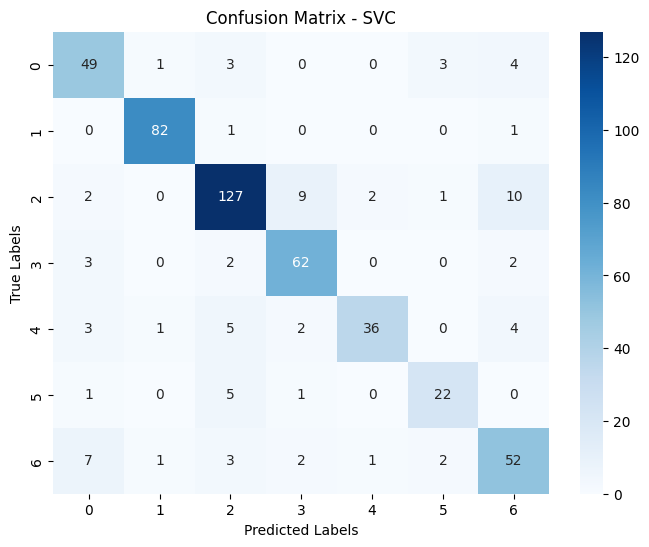

Metrics Table:
              precision    recall  f1-score  support
0              0.753846  0.816667  0.784000     60.0
1              0.964706  0.976190  0.970414     84.0
2              0.869863  0.841060  0.855219    151.0
3              0.815789  0.898551  0.855172     69.0
4              0.923077  0.705882  0.800000     51.0
5              0.785714  0.758621  0.771930     29.0
6              0.712329  0.764706  0.737589     68.0
accuracy       0.839844  0.839844  0.839844    512.0
macro avg      0.832189  0.823097  0.824903    512.0
weighted avg   0.844152  0.839844  0.839925    512.0


,precision,recall,f1-score,support
0,0.753846,0.816667,0.784000,60.0
1,0.964706,0.976190,0.970414,84.0
2,0.869863,0.841060,0.855219,151.0
3,0.815789,0.898551,0.855172,69.0
4,0.923077,0.705882,0.800000,51.0
5,0.785714,0.758621,0.771930,29.0
6,0.712329,0.764706,0.737589,68.0
accuracy,0.839844,0.839844,0.839844,512.0
macro avg,0.832189,0.823097,0.824903,512.0
weighted avg,0.844152,0.839844,0.839925,512.0


In [117]:
# 2. Support Vector Machine
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
evaluate_model(SVC(random_state=42), svm_param_grid)

# Analyse des Résultats pour Support Vector Classifier (SVC)

### **1. Matrice de Confusion**
- La matrice de confusion montre que le modèle SVC est globalement performant, avec des prédictions correctes majoritairement concentrées sur la diagonale.
- **Classes avec de bonnes prédictions** :
  - La classe `1` est presque parfaitement prédite (82 instances correctes sur 84).
  - La classe `2` montre également de solides performances avec 127 prédictions correctes.
- **Confusions notables** :
  - Les classes `5` et `6` présentent des confusions avec d'autres classes, notamment `2` et `3`.
  - Ces chevauchements sont cohérents avec des similarités dans les caractéristiques de ces classes.

---

### **2. Tableau des Métriques**
Le tableau des métriques donne une vue détaillée des performances par classe :

#### Observations Clés :
- **Précision Globale (accuracy)** : 83.98%, ce qui est légèrement supérieur au modèle Random Forest.
- **Classes avec Meilleures Performances** :
  - La classe `1` a une précision (96.47%) et un rappel (97.62%) remarquables, montrant que le modèle différencie très bien cette classe.
  - La classe `3` présente un excellent F1-score (85.52%), indiquant une forte cohérence entre précision et rappel.
- **Classes avec Performances Plus Faibles** :
  - La classe `5` a un rappel plus faible (75.86%), montrant que le modèle a encore du mal à capturer toutes les instances de cette classe.
  - La classe `6` montre des performances modérées, avec un F1-score de 73.76% et une précision de 71.23%.

#### Moyennes :
- **Macro avg** (moyenne non pondérée) :
  - La précision moyenne est de 83.22%, montrant que le modèle fonctionne bien sur la majorité des classes.
  - Le rappel moyen est légèrement inférieur (82.31%), indiquant des difficultés avec certaines classes minoritaires.
- **Weighted avg** (pondérée par le support) :
  - Très proche de l'accuracy globale (83.98%), confirmant une performance équilibrée sur les classes majoritaires.

---

### **3. Comparaison avec Random Forest**
- Le SVC surpasse le modèle Random Forest en précision globale (83.98% contre 83.20%).
- La classe `1` est mieux capturée par SVC grâce à son algorithme basé sur les marges maximales.
- Les confusions des classes `5` et `6` sont similaires dans les deux modèles, suggérant des limites inhérentes aux données ou aux caractéristiques.

---



### **Conclusion**
Le modèle SVC offre des performances globalement supérieures à Random Forest, avec une meilleure précision et un rappel plus élevé. Les classes majoritaires sont bien capturées, mais des confusions subsistent sur les classes minoritaires, qui nécessitent des ajustements pour être mieux différenciées.



Evaluating KNeighborsClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9585649202733485


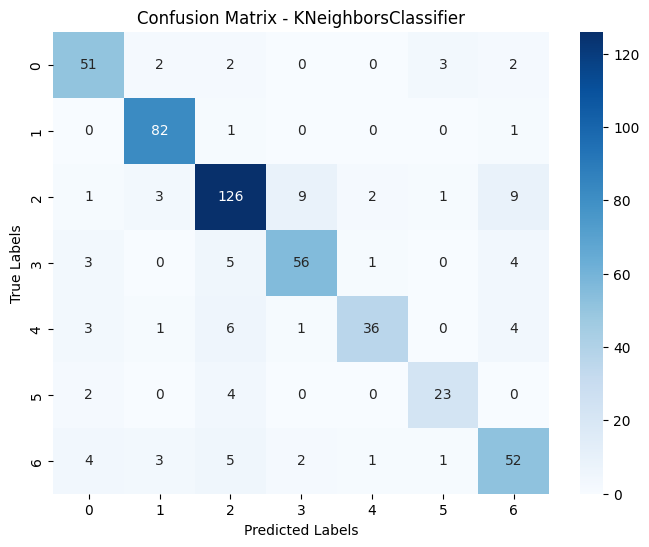

Metrics Table:
              precision    recall  f1-score  support
0              0.796875  0.850000  0.822581     60.0
1              0.901099  0.976190  0.937143     84.0
2              0.845638  0.834437  0.840000    151.0
3              0.823529  0.811594  0.817518     69.0
4              0.900000  0.705882  0.791209     51.0
5              0.821429  0.793103  0.807018     29.0
6              0.722222  0.764706  0.742857     68.0
accuracy       0.832031  0.832031  0.832031    512.0
macro avg      0.830113  0.819416  0.822618    512.0
weighted avg   0.833696  0.832031  0.831236    512.0


,precision,recall,f1-score,support
0,0.796875,0.850000,0.822581,60.0
1,0.901099,0.976190,0.937143,84.0
2,0.845638,0.834437,0.840000,151.0
3,0.823529,0.811594,0.817518,69.0
4,0.900000,0.705882,0.791209,51.0
5,0.821429,0.793103,0.807018,29.0
6,0.722222,0.764706,0.742857,68.0
accuracy,0.832031,0.832031,0.832031,512.0
macro avg,0.830113,0.819416,0.822618,512.0
weighted avg,0.833696,0.832031,0.831236,512.0


In [118]:
# 3. K-Nearest Neighbors
knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan or Euclidean distance
}
evaluate_model(KNeighborsClassifier(), knn_param_grid)

# Analyse des Résultats pour K-Nearest Neighbors (KNN)

### **1. Matrice de Confusion**
- La matrice de confusion montre que KNN est capable de prédire correctement un grand nombre d'instances pour les classes majoritaires.
- **Classes avec de bonnes prédictions** :
  - La classe `1` est prédite presque parfaitement (82 sur 84), ce qui montre une capacité à différencier cette classe.
  - La classe `2` obtient également un nombre élevé de prédictions correctes (126 sur 151).
- **Confusions observées** :
  - Les classes `5` et `6` présentent des confusions notables, notamment avec les classes `2` et `3`, reflétant des similarités entre ces groupes.
  - Quelques erreurs sont également observées pour la classe `0`.

---

### **2. Tableau des Métriques**
Le tableau des métriques fournit des détails clés sur la précision, le rappel, et le F1-score pour chaque classe :

#### Observations Clés :
- **Précision Globale (accuracy)** : 83.20%, ce qui est comparable aux modèles Random Forest et SVC.
- **Classes avec Meilleures Performances** :
  - La classe `1` a un F1-score très élevé (93.71%) grâce à une excellente précision (90.11%) et un rappel (97.61%).
  - La classe `0` montre également de bonnes performances avec un F1-score de 82.26%.
- **Classes avec Performances Plus Faibles** :
  - La classe `6` obtient un F1-score de 74.26%, indiquant des confusions fréquentes.
  - La classe `5` montre des métriques plus équilibrées mais légèrement faibles avec un F1-score de 80.70%.

#### Moyennes :
- **Macro avg** :
  - La précision moyenne est de 83.01%, montrant une performance globalement équilibrée.
  - Le rappel moyen est légèrement inférieur (81.94%), indiquant que certaines classes ne sont pas entièrement capturées.
- **Weighted avg** :
  - Très proche de l'accuracy globale (83.20%), ce qui reflète des performances stables même avec des classes déséquilibrées.

---

### **3. Comparaison avec d'autres Modèles**
- **Par rapport à SVC** :
  - KNN est légèrement en retrait en termes de précision globale, SVC ayant une meilleure performance pour les classes minoritaires.
- **Par rapport à Random Forest** :
  - Les deux modèles sont comparables en accuracy, mais Random Forest montre une meilleure capacité à traiter les classes `5` et `6`.
- **Avantage Principal de KNN** :
  - Simple à implémenter et très performant pour les classes bien représentées comme `1` et `2`.

---





### **Conclusion**
Le modèle KNN est performant pour la majorité des classes avec une précision globale de 83.20%. Cependant, il montre des limites pour les classes minoritaires, nécessitant des ajustements ou des méthodes complémentaires pour améliorer ces résultats.



Evaluating XGBClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\LG Gram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.9508221163802031


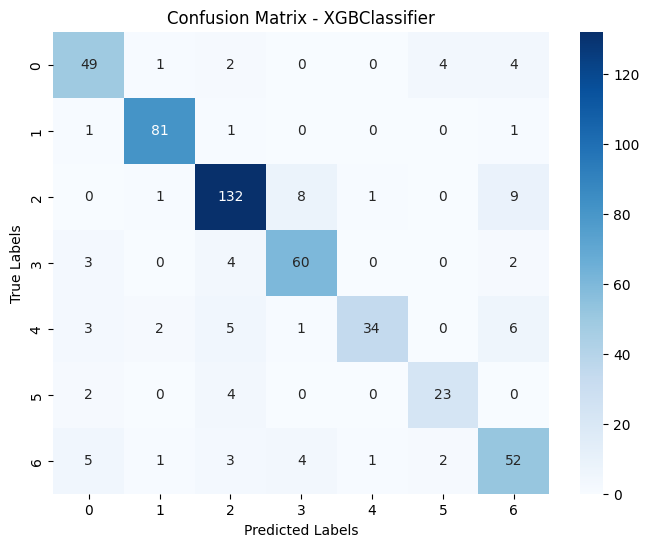

Metrics Table:
              precision    recall  f1-score  support
0              0.777778  0.816667  0.796748     60.0
1              0.941860  0.964286  0.952941     84.0
2              0.874172  0.874172  0.874172    151.0
3              0.821918  0.869565  0.845070     69.0
4              0.944444  0.666667  0.781609     51.0
5              0.793103  0.793103  0.793103     29.0
6              0.702703  0.764706  0.732394     68.0
accuracy       0.841797  0.841797  0.841797    512.0
macro avg      0.836568  0.821309  0.825148    512.0
weighted avg   0.846574  0.841797  0.841458    512.0


,precision,recall,f1-score,support
0,0.777778,0.816667,0.796748,60.0
1,0.941860,0.964286,0.952941,84.0
2,0.874172,0.874172,0.874172,151.0
3,0.821918,0.869565,0.845070,69.0
4,0.944444,0.666667,0.781609,51.0
5,0.793103,0.793103,0.793103,29.0
6,0.702703,0.764706,0.732394,68.0
accuracy,0.841797,0.841797,0.841797,512.0
macro avg,0.836568,0.821309,0.825148,512.0
weighted avg,0.846574,0.841797,0.841458,512.0


In [119]:
# 4. XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_param_grid)

# Analyse des Résultats pour XGBoostClassifier

### **1. Matrice de Confusion**
- La matrice de confusion montre que XGBoost offre des prédictions globalement précises avec une majorité d'instances correctement classées.
- **Classes avec de bonnes performances** :
  - La classe `1` est presque parfaitement classée (81 sur 84), démontrant la capacité du modèle à bien différencier cette classe.
  - La classe `2` affiche 132 instances correctes sur 151, confirmant une forte performance.
- **Confusions observées** :
  - Les classes `5` et `6` présentent des confusions avec `2` et d'autres classes, reflétant des similitudes dans les caractéristiques de ces groupes.

---

### **2. Tableau des Métriques**
Le tableau des métriques fournit des informations détaillées par classe :

#### Observations Clés :
- **Précision Globale (accuracy)** : 84.18%, ce qui est la meilleure performance parmi les modèles testés jusqu'à présent.
- **Classes avec Meilleures Performances** :
  - La classe `1` affiche un F1-score exceptionnel de 95.29%, avec une précision et un rappel très élevés.
  - La classe `2` suit avec un F1-score élevé de 87.41%, montrant un bon équilibre entre précision et rappel.
- **Classes avec Performances Plus Faibles** :
  - La classe `6` obtient un F1-score de 73.23%, indiquant des confusions notables.
  - La classe `4` présente un rappel plus faible (66.67%), suggérant des erreurs dans la classification de cette classe.

#### Moyennes :
- **Macro avg** :
  - Une précision moyenne de 83.66% et un rappel moyen de 82.13%, reflétant des performances globales solides sur toutes les classes.
- **Weighted avg** :
  - Très proche de l'accuracy (84.18%), ce qui confirme la capacité de XGBoost à équilibrer les performances entre classes majoritaires et minoritaires.

---

### **3. Comparaison avec d'autres Modèles**
- **Par rapport à Random Forest et SVC** :
  - XGBoost dépasse légèrement Random Forest et SVC en termes de précision globale, notamment grâce à une meilleure gestion des classes majoritaires.
- **Par rapport à KNN** :
  - XGBoost est nettement plus performant, en particulier sur les classes difficiles comme `5` et `6`, où il montre des métriques supérieures.

---



### **Conclusion**
XGBoost est le modèle le plus performant sur ce dataset, avec une précision globale de 84.18% et des prédictions fiables sur les classes majoritaires. Bien que des confusions subsistent pour les classes minoritaires (`5`, `6`), le modèle démontre une capacité supérieure à capturer des relations complexes dans les données.


### **Résumé**
- **Meilleure performance globale** : XGBoost et SVM.
- **Méthode la plus rapide** : Naive Bayes.
- **Méthode la plus équilibrée** : Random Forest.
- **Méthode la moins performante** : KNN (faible gestion des classes minoritaires).